<a href="https://colab.research.google.com/github/Brandonff13/IdentificacionModelos/blob/master/dmdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estrategia: Modo dominante


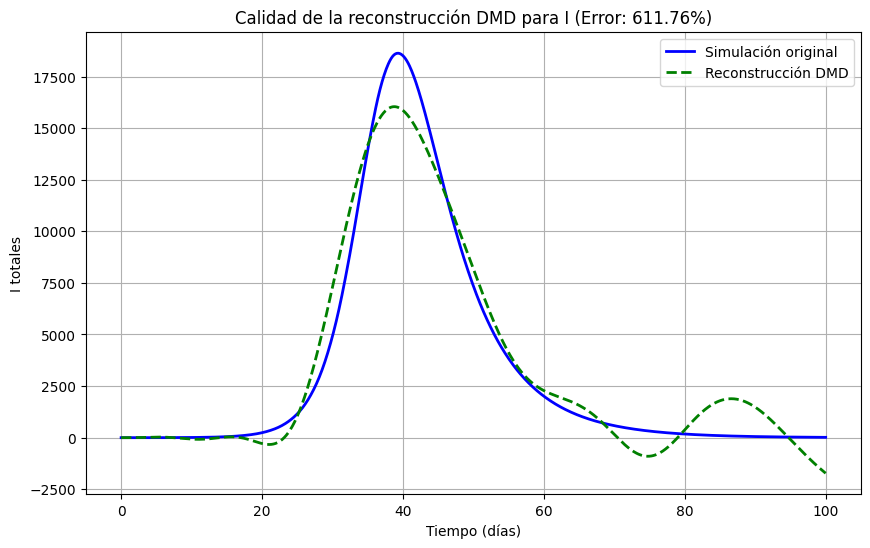

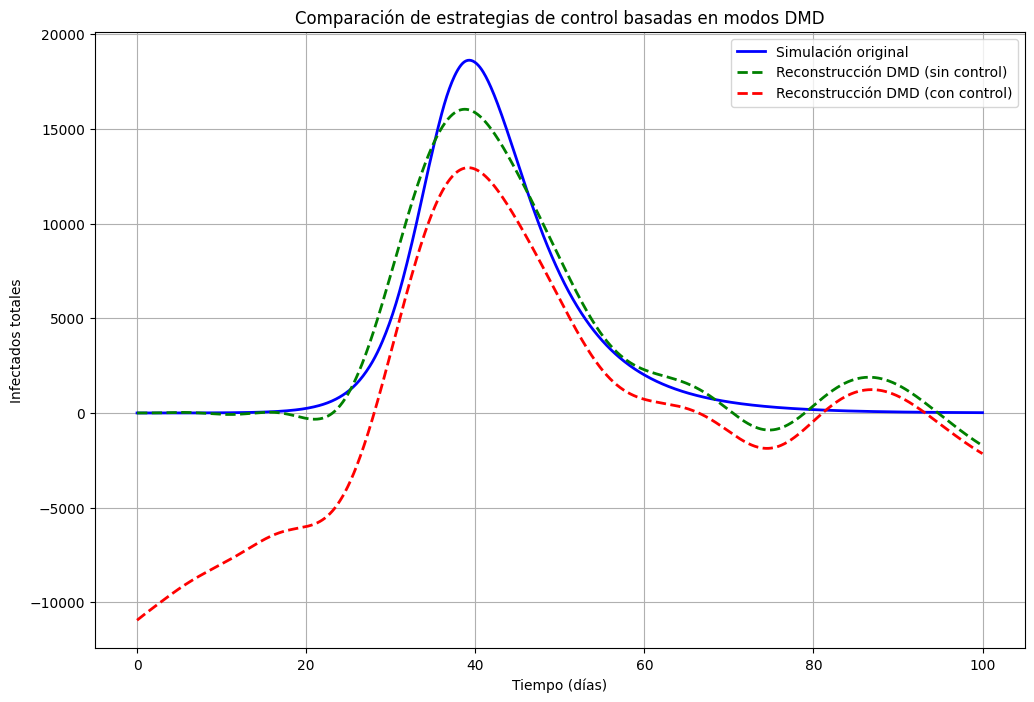

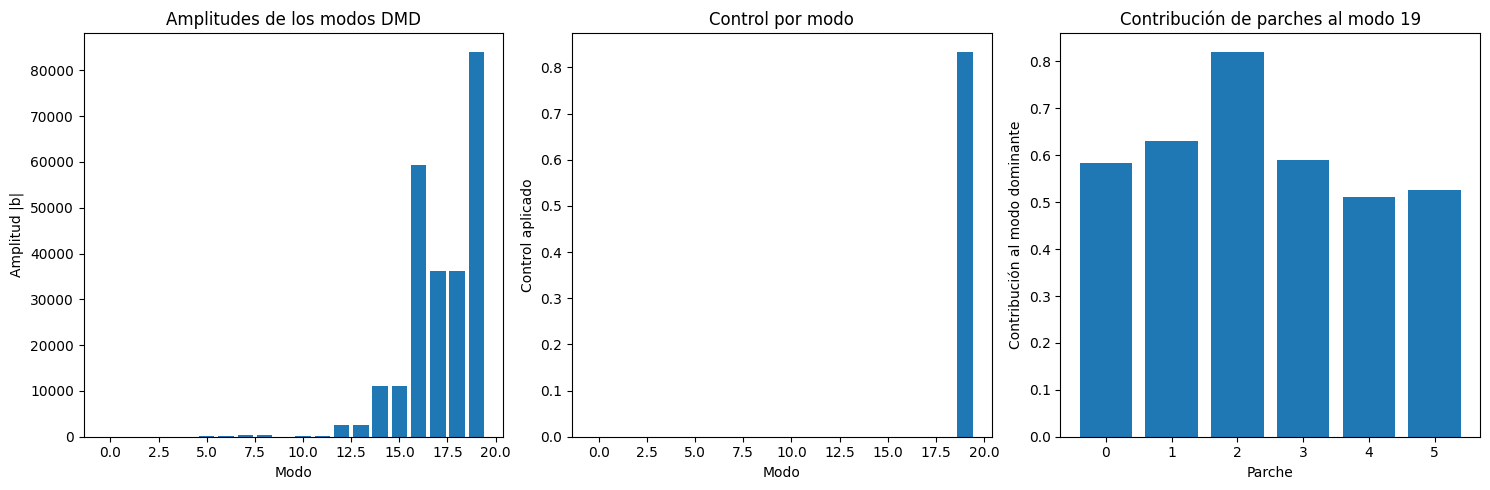

Estrategia: Homogéneo


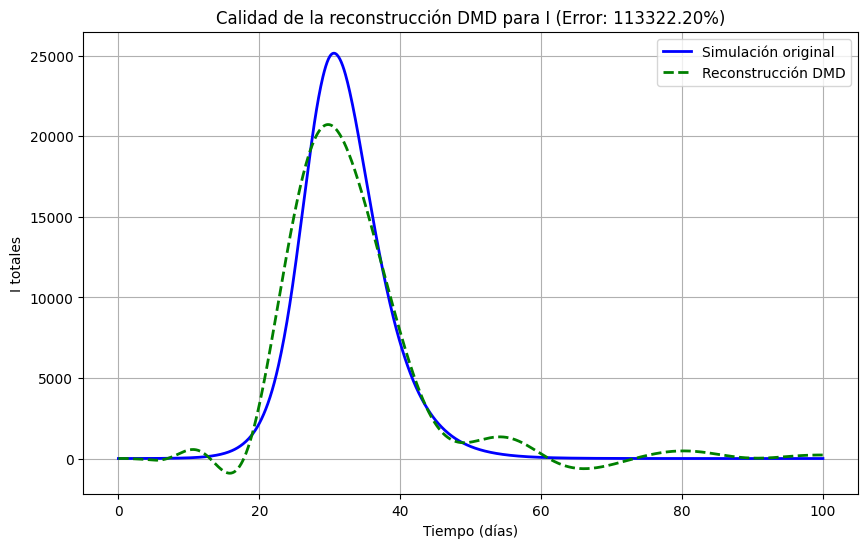

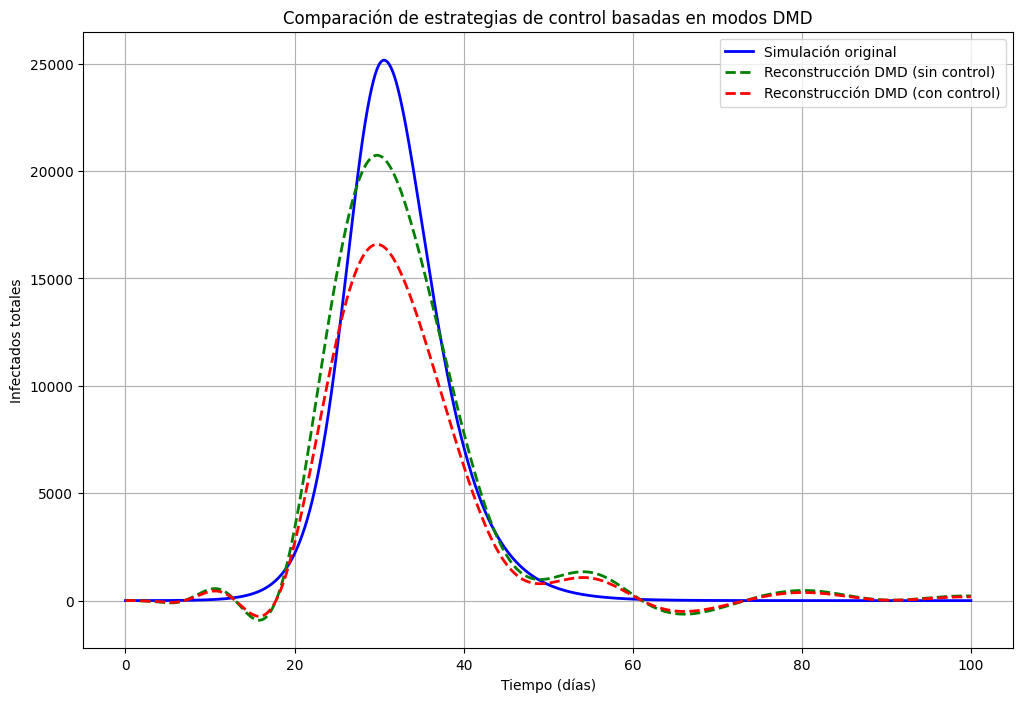

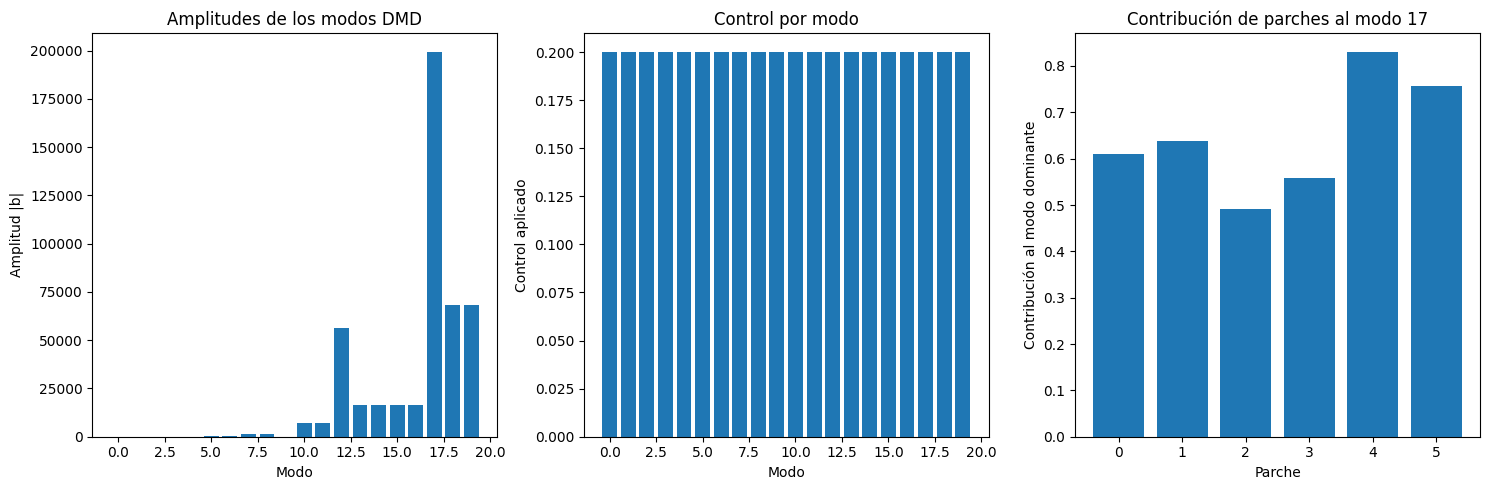

In [ ]:
import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import svd

# Parámetros epidemiológicos
params = {
    'beta_range': (0.59, 1.68),
    'kappa_range': (0.33, 0.5),
    'gamma_range': (0.1, 1.0),
    'epsilon': 1/8,
    'N_range': (15000, 35000),
}

# Función para generar la red de movilidad
def generar_red(n, tipo='BA'):
    if tipo == 'BA':
        G = nx.barabasi_albert_graph(n, m=2)
    else:
        G = nx.erdos_renyi_graph(n, p=0.5)
    P = nx.to_numpy_array(G).astype(float)
    for i in range(n):
        P[i, i] = 0.9
        P[i, :] /= P[i, :].sum()
    return P

# Función para inicializar parches
def inicializar_parches(n):
    N = np.random.randint(*params['N_range'], size=n)
    S0 = N.astype(float).copy()
    E0 = np.zeros(n)
    I0 = np.zeros(n)
    R0 = np.zeros(n)
    S0[0] -= 2
    E0[0] = 1
    I0[0] = 1
    beta = np.random.uniform(*params['beta_range'], size=n)
    kappa = np.random.uniform(*params['kappa_range'], size=n)
    gamma = np.random.uniform(*params['gamma_range'], size=n)
    return N, S0, E0, I0, R0, beta, kappa, gamma

# Función para construir la matriz beta
def construir_beta_mat(beta, P, N):
    n = len(beta)
    w = P.T.dot(N)
    beta_mat = np.zeros((n, n))
    for k in range(n):
        beta_mat += beta[k] * np.outer(P[:, k], P[:, k]) / w[k]
    return beta_mat

# Modelo SEIR
def modelo_SEIR(t, y, n, beta_mat, kappa, gamma, epsilon):
    S, E, I, R = y[:n], y[n:2*n], y[2*n:3*n], y[3*n:]
    inf = beta_mat.dot(I + epsilon * E)
    dSdt = -S * inf
    dEdt = S * inf - kappa * E
    dIdt = kappa * E - gamma * I
    dRdt = gamma * I
    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

# Función para aplicar DMD
def aplicar_DMD(X, r):
    X1 = X[:, :-1]
    X2 = X[:, 1:]

    U, Sigma, VT = svd(X1, full_matrices=False)
    U_r = U[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    VT_r = VT[:r, :]

    A_tilde = U_r.T @ X2 @ VT_r.T @ np.linalg.inv(Sigma_r)
    eigvals, W = np.linalg.eig(A_tilde)
    Phi = X2 @ VT_r.T @ np.linalg.inv(Sigma_r) @ W

    # Calcular coeficientes iniciales
    b = np.linalg.pinv(Phi) @ X[:, 0]

    return Phi, eigvals, b, Sigma

# Función para reconstruir la señal usando DMD
def reconstruir_DMD(Phi, b, omega, t):
    """
    Reconstruye la señal usando los modos DMD
    """
    n_modos = len(b)
    T = len(t)

    # Dinámica temporal
    dynamics = np.zeros((n_modos, T), dtype=complex)
    for i in range(T):
        dynamics[:, i] = b * np.power(omega, i)

    # Reconstrucción
    X_reconstruido = Phi @ dynamics

    return X_reconstruido.real

# Estrategias de control basadas en modos DMD
def control_modo_dominante(Phi, b, total_recursos, K=1):
    """
    Aplica todos los recursos al modo más dominante (mayor amplitud |b|)
    """
    # Encontrar el modo con la mayor amplitud
    modo_dominante = np.argmax(np.abs(b))

    # Aplicar todos los recursos a este modo
    control_vector = np.zeros(len(b))
    control_vector[modo_dominante] = total_recursos / (K + total_recursos)

    return control_vector

def control_homogeneo_modos(Phi, b, total_recursos, K=1):
    """
    Distribuye los recursos uniformemente entre todos los modos
    """
    n_modos = len(b)
    recursos_por_modo = total_recursos / n_modos
    control_vector = np.ones(n_modos) * recursos_por_modo / (K + recursos_por_modo)

    return control_vector

# Función para aplicar control a los modos DMD
def aplicar_control_DMD(Phi, b, omega, t, control_vector):
    """
    Aplica control a la reconstrucción DMD modificando las amplitudes de los modos
    """
    n_modos = len(b)
    T = len(t)

    # Modificar amplitudes según el control
    b_control = b * (1 - control_vector)

    # Reconstruir la señal con control
    X_control = reconstruir_DMD(Phi, b_control, omega, t)

    return X_control

# Función de simulación con control en modos DMD
def simular_control_modos_DMD(n=6, tipo_red='BA', t_max=100, estrategia='modo_dominante', total_recursos=10, r_modos=10):
    # Simular sin control
    P = generar_red(n, tipo_red)
    N, S0, E0, I0, R0, beta, kappa, gamma = inicializar_parches(n)
    beta_mat = construir_beta_mat(beta, P, N)

    y0 = np.concatenate([S0, E0, I0, R0])
    sol = solve_ivp(modelo_SEIR, (0, t_max), y0,
                    args=(n, beta_mat, kappa, gamma, params['epsilon']),
                    t_eval=np.linspace(0, t_max, 1000))

    # Preparar datos para DMD
    X = np.vstack([sol.y[:n], sol.y[n:2*n], sol.y[2*n:3*n], sol.y[3*n:]])

    # Aplicar DMD
    Phi, eigvals, b, Sigma = aplicar_DMD(X, r_modos)

    # Calcular frecuencias (omega)
    omega = eigvals

    # Reconstrucción sin control
    X_reconstruido = reconstruir_DMD(Phi, b, omega, sol.t)

    # Determinar estrategia de control
    if estrategia == 'modo_dominante':
        control_vector = control_modo_dominante(Phi, b, total_recursos)
    elif estrategia == 'homogeneo':
        control_vector = control_homogeneo_modos(Phi, b, total_recursos)
    else:
        control_vector = np.zeros(len(b))

    # Aplicar control a la reconstrucción DMD
    X_control = aplicar_control_DMD(Phi, b, omega, sol.t, control_vector)

    return sol, X_reconstruido, X_control, control_vector, Phi, b

# Visualización de resultados
def visualizar_control_modos(sol, X_reconstruido, X_control, n):
    plt.figure(figsize=(12, 8))

    # Sin control (simulación original)
    I_total = sol.y[2*n:3*n, :].sum(axis=0)
    plt.plot(sol.t, I_total, 'b-', label='Simulación original', linewidth=2)

    # Reconstrucción DMD sin control
    I_reconstruido = X_reconstruido[2*n:3*n, :].sum(axis=0)
    plt.plot(sol.t, I_reconstruido, 'g--', label='Reconstrucción DMD (sin control)', linewidth=2)

    # Con control (reconstrucción DMD con control)
    I_control = X_control[2*n:3*n, :].sum(axis=0)
    plt.plot(sol.t, I_control, 'r--', label='Reconstrucción DMD (con control)', linewidth=2)

    plt.xlabel('Tiempo (días)')
    plt.ylabel('Infectados totales')
    plt.title('Comparación de estrategias de control basadas en modos DMD')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualización de modos y control aplicado
def visualizar_modos_control(Phi, b, control_vector, n):
    n_modos = len(b)

    plt.figure(figsize=(15, 5))

    # Amplitudes de los modos
    plt.subplot(1, 3, 1)
    plt.bar(range(n_modos), np.abs(b))
    plt.xlabel('Modo')
    plt.ylabel('Amplitud |b|')
    plt.title('Amplitudes de los modos DMD')

    # Control aplicado a cada modo
    plt.subplot(1, 3, 2)
    plt.bar(range(n_modos), control_vector)
    plt.xlabel('Modo')
    plt.ylabel('Control aplicado')
    plt.title('Control por modo')

    # Contribución de parches al modo dominante
    modo_dominante = np.argmax(np.abs(b))
    plt.subplot(1, 3, 3)
    contribuciones = np.abs(Phi[:, modo_dominante].reshape(4, n)).sum(axis=0)
    plt.bar(range(n), contribuciones)
    plt.xlabel('Parche')
    plt.ylabel('Contribución al modo dominante')
    plt.title(f'Contribución de parches al modo {modo_dominante}')

    plt.tight_layout()
    plt.show()

# Visualización de la calidad de la reconstrucción DMD
def visualizar_calidad_reconstruccion(sol, X_reconstruido, n, variable='I'):
    """
    Compara la simulación original con la reconstrucción DMD para una variable específica
    """
    # Determinar índices según variable
    var_indices = {'S': (0, n), 'E': (n, 2*n), 'I': (2*n, 3*n), 'R': (3*n, 4*n)}
    start, end = var_indices[variable]

    # Datos originales
    V_original = sol.y[start:end, :].sum(axis=0)

    # Datos reconstruidos
    V_reconstruido = X_reconstruido[start:end, :].sum(axis=0)

    # Calcular error de reconstrucción
    error = np.mean(np.abs(V_original - V_reconstruido) / V_original) * 100

    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, V_original, 'b-', label='Simulación original', linewidth=2)
    plt.plot(sol.t, V_reconstruido, 'g--', label='Reconstrucción DMD', linewidth=2)
    plt.xlabel('Tiempo (días)')
    plt.ylabel(f'{variable} totales')
    plt.title(f'Calidad de la reconstrucción DMD para {variable} (Error: {error:.2f}%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
if __name__ == '__main__':
    n_parches = 6
    total_recursos = 5
    r_modos = 20  # Número de modos a considerar

    # Estrategia 1: Modo dominante
    print("Estrategia: Modo dominante")
    sol, X_reconstruido, X_control, control_vector, Phi, b = simular_control_modos_DMD(
        n=n_parches, estrategia='modo_dominante',
        total_recursos=total_recursos, r_modos=r_modos
    )

    # Visualizar calidad de la reconstrucción DMD
    visualizar_calidad_reconstruccion(sol, X_reconstruido, n_parches, variable='I')

    # Visualizar control aplicado
    visualizar_control_modos(sol, X_reconstruido, X_control, n_parches)
    visualizar_modos_control(Phi, b, control_vector, n_parches)

    # Estrategia 2: Homogéneo
    print("Estrategia: Homogéneo")
    sol, X_reconstruido, X_control, control_vector, Phi, b = simular_control_modos_DMD(
        n=n_parches, estrategia='homogeneo',
        total_recursos=total_recursos, r_modos=r_modos
    )

    # Visualizar calidad de la reconstrucción DMD
    visualizar_calidad_reconstruccion(sol, X_reconstruido, n_parches, variable='I')

    # Visualizar control aplicado
    visualizar_control_modos(sol, X_reconstruido, X_control, n_parches)
    visualizar_modos_control(Phi, b, control_vector, n_parches)